In [18]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.isotonic import IsotonicRegression
from scipy.signal import savgol_filter
from sklearn.linear_model import LinearRegression

In [2]:
import sys
sys.path.append('../stan/')
from stan_utilities import get_model

## Load data

In [3]:
data_dir = '../data/'
files = ! ls $data_dir

In [4]:
data_files = {}
for f in files:
    name = f.split('_')[0]
    typ = '_'.join(f.split('.')[0].split('_')[1:])
    if name not in data_files: data_files[name] = {}
    data_files[name][typ] = os.path.join(data_dir, f)

In [5]:
data = {}
for name, files in data_files.items():
    d = {}
    data[name] = d
    d['OD'] = pd.read_csv(files['OD'], sep=',', names=['time', 'OD'], header=0)
    d['pump_log'] = pd.read_csv(files['pump_log'], sep=',', names=['time', 'OD'], header=0)

In [6]:
vial = 'vial15a'

time = np.array(data[vial]['OD']['time'])
od = np.array(data[vial]['OD']['OD'])

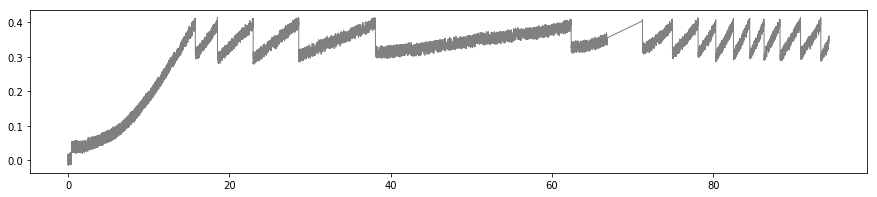

In [7]:
plt.figure(figsize=(15,3))
plt.plot(time, od, '-', lw=1, color='gray')
plt.show()

## Find log-OD center and width

In [8]:
def get_center_and_width(time, od):
    
    # Step 1: remove non-positive OD
    positive_od = od > 0
    od_pos = od[positive_od]
    
    # Step 2: determine width
    model = get_model('../stan/width_estimation_model.stan', 
                      '../stan/width_estimation_model.pkl')
    log_OD = np.log(od_pos)
    
    data_dict = {
    'N': len(log_OD),
    'x': log_OD
    }
    mu0 = np.median(log_OD)
    sigma0 = 2*(np.percentile(log_OD, 75) - np.percentile(log_OD, 25))
    fit = model.optimizing(data_dict, init=lambda : 
                              {
                                  'mu': mu0,
                                  'sigma': sigma0,
                                  'm': mu0,
                                  's': 3 * sigma0,
                                  'w': [0.8, 0.2]
                              }
                            )
    width = np.sqrt(12) * fit['sigma']
    center = fit['mu']
    
    return center, width

In [9]:
log_od_center, log_od_width = get_center_and_width(time, od)
np.exp(log_od_center - 0.5*log_od_width), np.exp(log_od_center + 0.5*log_od_width),

(0.2998870368915642, 0.3944435857747305)

In [10]:
width_factor = 1.5
low_od = np.exp(log_od_center - width_factor * log_od_width / 2)
high_od = np.exp(log_od_center + width_factor * log_od_width / 2)
selection = (low_od < od) & (od < high_od)

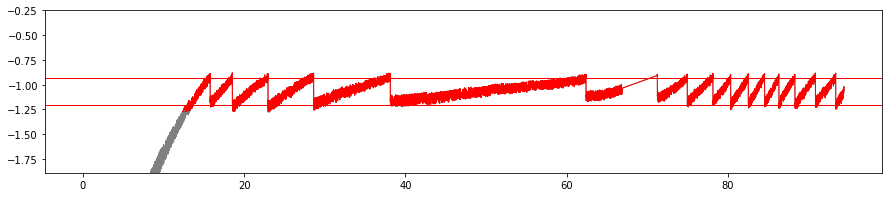

In [11]:
plt.figure(figsize=(15,3))
plt.plot(time[od > 0], np.log(od[od > 0]), '-', lw=1, color='gray', )
plt.plot(time[selection], np.log(od[selection]), '-', lw=1, color='r', )
low = log_od_center - log_od_width / 2
high = log_od_center + log_od_width / 2
plt.axhline(low, color='r', lw=1)
plt.axhline(high, color='r', lw=1)
plt.ylim([log_od_center - 3*log_od_width, log_od_center + 3*log_od_width])
plt.show()

In [12]:
t_raw = time[selection]
x_raw = np.log(od[selection])

In [13]:
x_filtered = savgol_filter(x_raw, window_length=41, polyorder=2)

/Users/peterkomar/.pyenv/versions/3.6.5/lib/python3.6/site-packages/scipy/linalg/basic.py:1018: RuntimeWarning: internal gelsd driver lwork query error, required iwork dimension not returned. This is likely the result of LAPACK bug 0038, fixed in LAPACK 3.2.2 (released July 21, 2010). Falling back to 'gelss' driver.
  warnings.warn(mesg, RuntimeWarning)
/Users/peterkomar/.pyenv/versions/3.6.5/lib/python3.6/site-packages/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]


In [58]:
def find_regions(t, x, minimum_datapoints=10, mu_factor=0.5, low_density_factor=0.01):
    # find gaps in the data
    avg_dt = (t[-1] - t[0]) / (len(t) - 1)
    gap_start_idexes = np.where(np.diff(t) > avg_dt / low_density_factor)[0]
    
    # build initial set of regions from these gaps
    s_raw = [0]
    e_raw = []
    for gap_idx in gap_start_idexes:
        e_raw.append(gap_idx)
        s_raw.append(gap_idx + 1)
    e_raw.append(len(t) - 1)
    regions_to_investigate = list(zip(s_raw, e_raw))
    
    s = []
    e = []
    while len(regions_to_investigate) > 0:
        
        # pick a new region
        start_idx, end_idx = regions_to_investigate.pop()
        
        # check that there are at least a minimum number of datapoints
        if end_idx - start_idx + 1 < minimum_datapoints:
            continue
        
        # find optimal drift
        t_region = t[start_idx:end_idx+1]
        x_region = x[start_idx:end_idx+1]
        mu_min = LinearRegression(fit_intercept=True) \
                 .fit(t_region.reshape([-1, 1]), 
                     x_region) \ 
                 .coef_
    
        # fit monotonic function
        x_drifting = x_region - t_region * mu_min * mu_factor
        iso_reg = IsotonicRegression(increasing=False) \
                  .fit(t_region, x_drifting)
        x_segmented = iso_reg.predict(t_region)
        
        # find jumps
        jump_indexes = np.where(np.diff(x_segmented) < 0)[0] + start_idx
        if len(jump_indexes) > 0:
            # if found, add the sub-regions to the list of new regions
            start_indexes = [start_idx]
            end_indexes = []
            for jump_idx in jump_indexes:
                end_indexes.append(jump_idx)
                start_indexes.append(jump_idx + 1)
            end_indexes.append(end_idx)
            for start_idx, end_idx in zip(start_indexes, end_indexes):
                regions_to_investigate.append((start_idx, end_idx))
        else:
            # if no subregions are found, add regions to final set
            s.append(start_idx)
            e.append(end_idx)

    s.sort()
    e.sort()    
    return np.array(s), np.array(e)

In [75]:
s, e = find_regions(t_raw, x_raw, minimum_datapoints=10, mu_factor=0.5, low_density_factor=0.01)
len(s), len(e)

(17, 17)

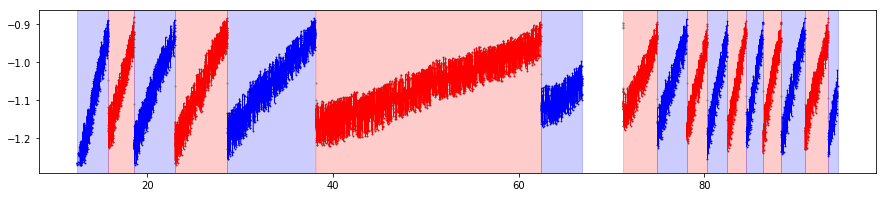

In [76]:
plt.figure(figsize=(15, 3))

plt.plot(t_raw, x_raw, '.', lw=1, color='gray', ms=2)
colors = ['blue', 'red']
for r, (sr, er) in enumerate(zip(s, e)):
    color = colors[r % len(colors)]
    plt.axvspan(t_raw[sr], t_raw[er], alpha=0.2, color=color)
    plt.plot(t_raw[sr:er+1], x_raw[sr:er+1], '.-', lw=0.5, ms=1, color=color)
plt.show()

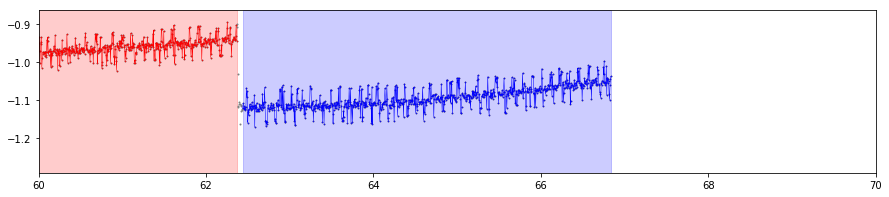

In [17]:
plt.figure(figsize=(15, 3))

plt.plot(t_raw, x_raw, '.', lw=1, color='gray', ms=2)
colors = ['blue', 'red']
for r, (sr, er) in enumerate(zip(s, e)):
    color = colors[r % len(colors)]
    plt.axvspan(t_raw[sr], t_raw[er], alpha=0.2, color=color)
    plt.plot(t_raw[sr:er+1], x_raw[sr:er+1], '.-', lw=0.5, ms=1, color=color)

plt.xlim([60, 70])
plt.show()

## Sweep mu, and record jumps

In [173]:
mus = np.linspace(0, 0.2, 400)
jump_times = []
mu_array = []
for mu in mus:
    x_drifting = x - mu * t
    iso_reg = IsotonicRegression(increasing=False).fit(t, x_drifting)
    x_segmented = iso_reg.predict(t)
    jump_indexes = np.arange(len(t)-1)[np.diff(x_segmented) < 0]
    for jump_idx in jump_indexes:
        jump_times.append(t[jump_idx])
        mu_array.append(mu)

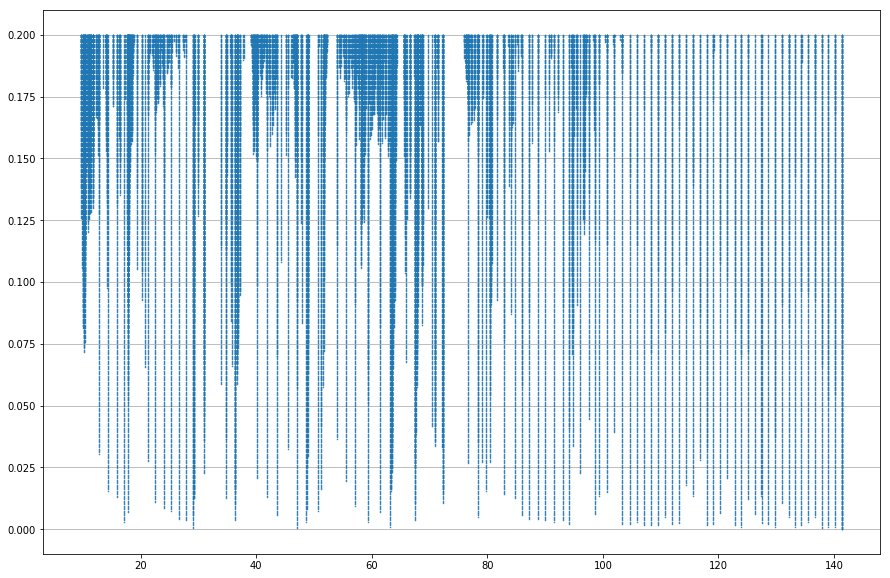

In [174]:
plt.figure(figsize=(15, 10))
plt.plot(jump_times, mu_array, '.', ms=1)
plt.grid(axis='y')
plt.show()

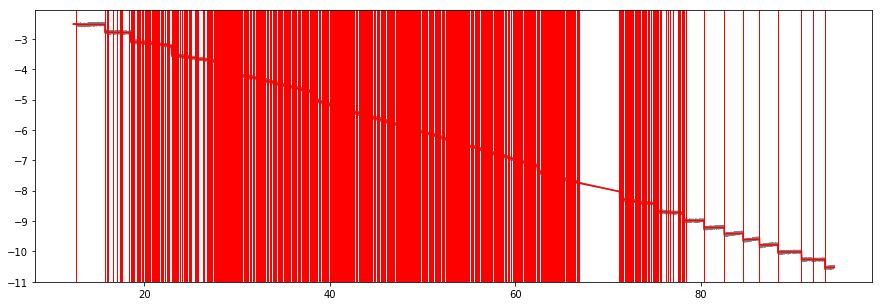

In [31]:
mu = 0.1
x_drifting = x - mu * t
iso_reg = IsotonicRegression(increasing=False).fit(t, x_drifting)
x_segmented = iso_reg.predict(t)
jump_indexes = np.arange(len(t)-1)[np.diff(x_segmented) < 0]

plt.figure(figsize=(15,5))
plt.plot(t, x_drifting, color='gray')
plt.plot(t, x_segmented, color='r')
for jump in jump_indexes:
    plt.axvline(t[jump], color='r', lw=1)
plt.show()